<a href="https://colab.research.google.com/github/AdrianPauer/MVOdata2023/blob/main/mvo2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moja mama optimalizuje lepšie ako tvoja : LOG REGRESIA 2023


## 1 Ťahanie Dát

In [ ]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import OptimizeResult

In [ ]:
!git clone https://github.com/AdrianPauer/MVOdata2023
table = pd.read_csv("MVOdata2023/credit_risk_train.csv",sep = ';')
table

fatal: destination path 'MVOdata2023' already exists and is not an empty directory.


,Creditability,Duration of Credit (month),Value Savings/Stocks,Length of current employment
0,0,24,1,2
1,0,36,1,5
2,0,6,4,2
3,0,12,1,3
4,0,24,3,5
...,...,...,...,...
694,0,20,1,3
695,0,9,1,3
696,0,18,1,5
697,0,24,1,2


## 2.1 Príprava na testovanie metód

### 2.1.1 Účelové funkcie 
Task A,B



In [ ]:
# f1 na ladanie metod
def f1(x, a=1):
    M = np.diag((1, a))
    h = np.array((a, a))
    return 0.5 * x@M@x - x@h

def df1 (x,a = 1):
    M = np.diag((1, a))
    h = np.array((a, a))
    return M@x - h
    
def J(x):
  sum = 0
  for index,row in table.iterrows():
    v = row[0]
    u = np.array(row[1:])
    x_u = x@u
    sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))
  return sum

def dfJ(x):
  sum = np.zeros_like(x)
  for index,row in table.iterrows():
    v = row[0]
    u = np.array(row[1:])
    x_u = x@u
    sum += u * (1-v) - (np.exp(-x_u)/(1 + np.exp(-x_u))) * u
  return sum 


In [ ]:

print(J(np.zeros(3)))
print(dfJ(np.zeros(3)))
print(np.exp(-0))

484.5098792114029
[-1890.5  -388.   -511. ]
1.0


###2.1.2 Metódy intervalovej aproximáci použité na hľadanie veľkosti kroku

In [ ]:
def backtracking_line_search(fun, jac, x0, args=(), s=None, max_stepsize=1,
                             rho=0.1, c=0.05, options={}):
    """
    Implements the backtracking line search algorithm to find the step size alpha
    for gradient descent.

    Parameters:
        f : callable
            Objective function.
        g : callable
            Gradient function.
        x0 : array-like
            Current point.
        s : array-like, optional
            Search direction. If not provided, gradient direction is used.
        max_stepsize : numeric, optional.
            Initial step size. Default is 1.
        rho : numeric, optional
            Shrinkage factor. Nonnegative number, less than one. Default is 0.1.
        c : numeric, optional
            Armijo condition parameter. Default is 0.05.
        options : dict, optional
            A diactionary with solver options.
                maxiter : int
                    Maximum number of iterations to perform.

    Returns
    -------
        stepsize : float
            Step size that satisfies the Armijo condition.
    """

    assert 0 < rho < 1, "Rho parameter should be from range (0, 1)!"

    maxiter = options.get("maxiter", 100)

    x = np.array(x0)
    if s is None:
        s = -jac(x, *args)
        df_s = -s@s
    else:
        df_s = jac(x, *args) @ s
    
    stepsize = max_stepsize

    fx = fun(x, *args)
  
    
    for it in range(maxiter):
        if fun(x + stepsize*s, *args) > fx + c*stepsize*df_s:
            stepsize *= rho
        else:
            return stepsize
    
    return stepsize

In [ ]:
def bisection(dfun, bounds=None, args=(), callback=None,
              options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    dfun : callable f(x, *args)
        Derivative of objective function to minimize.
    
    bounds : tuple of numeric sequence
        Two items corresponding to the optimization bounds.
    
    args : tuple, optional
        Extra arguments passed to the objective function.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform.
            tol : float
                Tolerance for termination

    **kwargs : dict, optional
        Other parameters passed to `bisection`.

    Raises
    ------
    ValueError
        if `bounds` is not provided.

    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """
    
    if bounds is None:
        raise ValueError("Must provide `bounds` parameter!\n Tuple of numeric sequence: two items corresponding to the optimization bounds.")

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-9)
    a, b = bounds

    #print('bisection')
    for it in range(maxiter):
        c = (a+b)/2
        dfc = dfun(c, *args)
        #print(c, dfc)
        if dfc > 0:
          b = c
        else:
          a = c
        if callback is not None:
            midpoint = (a+b) / 2
            callback(midpoint)
        
        if b - a < tol:
            break
    
    
    success = (b - a) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return  OptimizeResult(x= (b+a)/2, nit=it, njev=it, tol=tol, success=success,message = msg)

##2.2 TaskC

###2.2.1 bgfs

In [ ]:
def bfgs(fun, jac, x0, stepsize_method, args=(), callback=None, options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform. Default is 1000.
            tol : float
                Tolerance for termination. Default is 1e-8.
            H0 : array-like
                Initial approximation of inverse hessian. Default is
                identity matrix.
            max_stepsize: float
                Maximum step size for line search. Default is 10.

    **kwargs : dict, optional
        Other parameters passed to `bfgs`.


    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """

    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g
        
        if stepsize_method == 'bisection':
          dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
          stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
          stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)
        else :
          print('Zadaj metodu')
      
        x_old = x.copy()
        g_old = g.copy()

      
        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        pTy = p@y
        Hy = H@y
      
        deltaH = (1 + ( (y@H@y) / pTy ) ) * (np.outer(p,p) / pTy) - ( ( np.outer(Hy, p) + (np.outer(p,y))@H) / pTy )
        
        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x, *args)) <= tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) <= tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)


In [ ]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
bfgs(fun = J, jac=dfJ, x0 = np.zeros(3),stepsize_method = 'backtracking', callback=fill_bgfs, options = {'tol' : 1e-3})

<ipython-input-4-89d3f362e688>:18: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 8
    njev: 8

###2.2.2 dfp

In [ ]:
def dfp (fun, jac, x0, stepsize_method, args=(), callback=None, options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform. Default is 1000.
            tol : float
                Tolerance for termination. Default is 1e-8.
            H0 : array-like
                Initial approximation of inverse hessian. Default is
                identity matrix.
            max_stepsize: float
                Maximum step size for line search. Default is 10.

    **kwargs : dict, optional
        Other parameters passed to `bfgs`.


    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """

    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g

        if stepsize_method == 'bisection':
          dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
          stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
          stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)
        else :
          print('Zadaj metodu')
        
        x_old = x.copy()
        g_old = g.copy()

        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        Hy = H@y

    
        deltaH = ( np.outer(p,p) / (p@y) ) - ( np.outer(Hy,y@H) / (y@Hy) )  

        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x,*args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)


In [ ]:
dfp_iterations = []
fill_dfp = lambda x: dfp_iterations.append(x)
dfp(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='backtracking', callback=fill_dfp, options = {'tol' : 1e-3})

<ipython-input-4-89d3f362e688>:18: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 9
    njev: 9

##2.3 TaskD

In [ ]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
bfgs(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='bisection', callback=fill_bgfs, options = {'tol' : 1e-3,'max_stepsize' : 0.5})

 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 22
    njev: 22

##2.4 TaskE - kvázinewtonovské metódy

In [ ]:
def sr1(fun, jac, x0, stepsize_method, args=(), callback=None, options={}, **kwargs):
    """
    Minimization method

    Parameters
    ----------
    jac : callable f(x, *args)
        Gradient of objective function.
        
    x0 : array-like
        Initial guess. 
    
    args : tuple, optional
        Extra arguments passed to the `jac`.
    
    callback : callable f(x), optional
        Function called after each iteration.
    
    options : dict, optional
        A diactionary with solver options.
            maxiter : int
                Maximum number of iterations to perform. Default is 1000.
            tol : float
                Tolerance for termination. Default is 1e-8.
            H0 : array-like
                Initial approximation of inverse hessian. Default is
                identity matrix.
            max_stepsize: float
                Maximum step size for line search. Default is 10.

    **kwargs : dict, optional
        Other parameters passed to `bfgs`.


    Returns
    -------
    res : OptimizeResult
        The optimization result represented as a OptimizeResult object.
        Important attributes are: x the solution,
        success a Boolean flag indicating if the optimizer exited successfully,
        message which describes the cause of the termination.
        See OptimizeResult for a description of other attributes.
    """

    x = np.array(x0)
    n = len(x)

    maxiter = options.get("maxiter", 1000)
    tol = options.get("tol", 1e-8)
    H = options.get("H0", np.eye(n))
    max_stepsize = options.get("max_stepsize", 10)

    g = jac(x, *args)
    for it in range(maxiter):
        s = -H @ g

        dzuzenie = lambda a : (jac(x + a*s, *args)) @ s
        if stepsize_method == 'bisection':
          stepsize = bisection(dzuzenie, bounds = (0,max_stepsize)).x
        elif stepsize_method == 'backtracking':
          stepsize = backtracking_line_search(fun,jac,x,args,max_stepsize = max_stepsize, s = s)

        
        x_old = x.copy()
        g_old = g.copy()

        x = x + stepsize * s
        g = jac(x, *args)

        y = g - g_old
        p = x - x_old

        pHy = p - H@y
        deltaH = np.outer(pHy, pHy) / (y @ (pHy))  

        H = H + deltaH

        if callback is not None:
            callback(x)
        
        if np.linalg.norm(jac(x ,*args)) < tol:
            break
    
    
    success = np.linalg.norm(jac(x, *args)) < tol

    if success:
        msg = "Optimization successful"
    else:
        msg = "Optimization failed"
    
    return OptimizeResult(x = x, nit = it + 1, njev = it + 1, success = success, message = msg)

In [ ]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
sr1(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='bisection', callback=fill_bgfs, options = {'tol' : 1e-3, 'max_stepsize':0.5})

 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 22
    njev: 22

In [ ]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
sr1(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='backtracking', callback=fill_bgfs, options = {'tol' : 1e-3})

<ipython-input-4-89d3f362e688>:18: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 8
    njev: 8

In [ ]:
bfgs_iterations = []
fill_bgfs = lambda x: bfgs_iterations.append(x)
dfp(fun = J, jac=dfJ, x0 = np.zeros(3), stepsize_method='bisection', callback=fill_bgfs, options = {'tol' : 1e-3,'max_stepsize' : 0.5})

<ipython-input-4-89d3f362e688>:18: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


 message: Optimization successful
 success: True
       x: [-4.536e-02  3.277e-01  3.462e-01]
     nit: 24
    njev: 24

In [ ]:
def makeData(f, df, x0 = np.zeros(3), args = ()):  
  def append_item(l: list, new_item):
      l.append(new_item)
  data = []

  iter = []
  fill_iter = lambda x: append_item(iter, x)
  
  bgfs_back = bfgs(fun = f, jac = df, x0 = x0, stepsize_method = 'backtracking', args = args, callback=fill_iter, options = {'tol':1e-3, })
  solution = bgfs_back.x
  for i in range (0,len(iter)): data.append(['bgfs_back',i, J(iter[i]) - J(solution)])
 

  iter = []
  bgfs_bis = bfgs(fun = f, jac = df, x0 = x0, stepsize_method = 'bisection', args = args, callback=fill_iter, options = {'tol':1e-3, 'max_stepsize':0.5})
  solution = bgfs_bis.x
  for i in range (0,len(iter)): data.append(['bgfs_bis',i, J(iter[i]) - J(solution)])


  iter = []
  dfp_back = dfp(fun = f, jac = df, x0 = x0, stepsize_method = 'backtracking', args = args, callback=fill_iter, options = {'tol':1e-3})
  solution = dfp_back.x
  for i in range (0,len(iter)): data.append(['dfp_back',i, J(iter[i]) - J(solution)])
 
  iter = []
  dfp_bis = dfp(fun = f, jac = df, x0 = x0, stepsize_method = 'bisection', args = args, callback=fill_iter, options = {'tol':1e-3, 'max_stepsize':0.5})
  solution = dfp_bis.x
  for i in range (0,len(iter)): data.append(['dfp_bis',i, J(iter[i]) - J(solution)])
  

  iter = []
  sr1_back = sr1(fun = f, jac = df, x0 = x0, stepsize_method = 'backtracking', args = args, callback=fill_iter, options = {'tol':1e-3})
  solution = sr1_back.x
  for i in range (0,len(iter)): data.append(['sr1_back',i, J(iter[i]) - J(solution)])
  

  iter = []
  sr1_bis = sr1(fun = f, jac = df, x0 = x0, stepsize_method = 'bisection', args = args, callback=fill_iter, options = {'tol':1e-3, 'max_stepsize':0.5})
  solution = sr1_bis.x
  for i in range (0,len(iter)): data.append(['sr1_bis',i, J(iter[i]) - J(solution)])
  

  table = pd.DataFrame(data,columns = ['Method', 'iteration', 'diffrence'])
  return table

In [ ]:
table1 = makeData(J, dfJ)

<ipython-input-111-89d3f362e688>:18: RuntimeWarning: overflow encountered in exp
  sum += x_u * (1-v) +  np.log(1 + np.exp(-x_u))


In [ ]:
table1

,Method,iteration,diffrence
0,bgfs_back,0,7.619071e+01
1,bgfs_back,1,3.521694e+00
2,bgfs_back,2,3.474129e+00
3,bgfs_back,3,6.799094e-01
4,bgfs_back,4,9.267315e-03
...,...,...,...
86,sr1_bis,17,1.062915e-09
87,sr1_bis,18,2.627871e-10
88,sr1_bis,19,6.309619e-11
89,sr1_bis,20,1.284661e-11


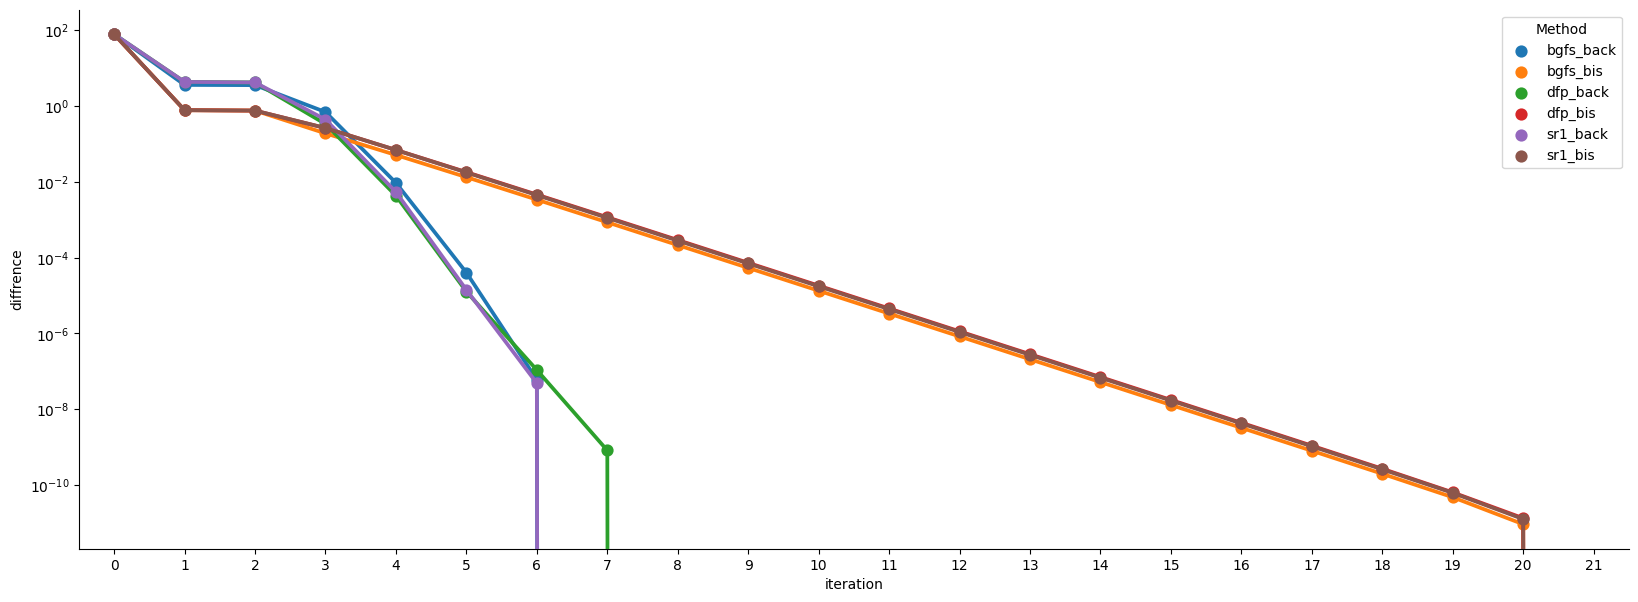

In [ ]:
fig, axs = plt.subplots(figsize = (20,7))
sns.set_style({'axes.spines.right': False,'axes.spines.left': True,'axes.spines.top': False})

axes = sns.pointplot(data=table1, x='iteration', y='diffrence',hue = 'Method',ax = axs)
plt.yscale('log')